# DIMLP Fidex

Here we provide a simple usecase of the DIMLP architecture and the Fidex algorithm. Detailed information on the DIMLP-Fidex framework are available [here](https://hes-xplain.github.io/documentation/dimlpfidex/overview/).  

This example is a simplified version of [this notebook](https://colab.research.google.com/github/HES-XPLAIN/notebooks/blob/main/use_case_dimlpfidex/omniXai_dimlpfidex.ipynb#scrollTo=Qj8ghhOJjNoH) available on the [HES-XPLAIN platform](https://hes-xplain.github.io/). Here we use the Diabetes dataset from Kaggle to show how rules can be extracted





In [11]:
use_colab = True

if use_colab:
  !pip install omnixai_community
  !pip install mlxplain
  !pip install dimlpfidex


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [12]:
import pandas as pd
import pathlib as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import kagglehub

from random import randint
import os
from omnixai_community.data.tabular import Tabular
from omnixai_community.visualization.dashboard import Dashboard
from omnixai_community.explainers.tabular.auto import TabularExplainer
from mlxplain.explainers.tabular.specific.dimlpfidex import DimlpBTModel
from dimlpfidex.dimlp import dimlpPred

# ------------------------

os.makedirs('./notebooks/dimlp', exist_ok=True)
root_dir = pl.Path("./notebooks/dimlp")

## Diabetes dataset

Here we take the same example dataset as for Random Forest


In [22]:
# Download latest version and import dataframe. Replace this with your own dataset
path = kagglehub.dataset_download("gargmanas/pima-indians-diabetes")
print("Path to dataset files:", path )

df = pd.read_csv(path + '/pima-indians-diabetes.csv')
df.columns = ['Pregnancies','Glucose','BloodPressure','SkinThickness','Insulin','BMI','DiabetesPedigreeFunction','Age','OUT']

# For this example, we also use one-hot encoding for the output variable
output = pd.get_dummies(
    df["OUT"], prefix="diabetes", prefix_sep="_", columns=["OUT"], dtype="int8"
)

df = pd.concat([df.iloc[:, :-1], output], axis=1)
df = df.rename(columns={"diabetes_0": "diabetes_no", "diabetes_1": "diabetes_yes"})

df


Path to dataset files: /home/twg/.cache/kagglehub/datasets/gargmanas/pima-indians-diabetes/versions/1


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,diabetes_no,diabetes_yes
0,1,85,66,29,0,26.6,0.351,31,1,0
1,8,183,64,0,0,23.3,0.672,32,0,1
2,1,89,66,23,94,28.1,0.167,21,1,0
3,0,137,40,35,168,43.1,2.288,33,0,1
4,5,116,74,0,0,25.6,0.201,30,1,0
...,...,...,...,...,...,...,...,...,...,...
762,10,101,76,48,180,32.9,0.171,63,1,0
763,2,122,70,27,0,36.8,0.340,27,1,0
764,5,121,72,23,112,26.2,0.245,30,1,0
765,1,126,60,0,0,30.1,0.349,47,0,1


In [23]:
# Split the dataset into train and test
train_df, test_df = train_test_split(df, test_size=0.2)

train_df = Tabular(train_df)
test_df_tab = Tabular(test_df)

# Get the features list and save it to a file
features = df.columns
features_filename = "attributes.txt"
pd.DataFrame(features.values).to_csv(root_dir.joinpath(features_filename), index=False, header=False)

# Global variables for the model
nb_classes = 2
nb_features = len(features) - nb_classes # The number of classes is 2 (diabetes or not) but as it is on one column, we need to remove it from the features.


We can now train the model using [DimlpBT](https://hes-xplain.github.io/documentation/dimlpfidex/dimlp/dimlpbt/#arguments-list) which uses bagging.

In [24]:
model_diabetes = DimlpBTModel(
    root_dir,
    train_df,
    test_df_tab,
    nb_features,
    nb_classes,
    attributes_file=features_filename,
    nb_dimlp_nets=10,
    with_rule_extraction=True,
)

model_diabetes.train()

0

## Results

In [25]:
# Predict outputs and compare them to the real outputs
dimlpPred(
    f"""
    --test_data_file test_data.txt
    --weights_file dimlpBT.wts
    --nb_attributes {nb_features}
    --hidden_layers_file hidden_layers.out
    --nb_classes {nb_classes}
    --test_pred_outfile predTest.out
    --root_folder {root_dir}
    """
)

Parameters list:
 - test_data_file                                                         notebooks/dimlp/test_data.txt
 - test_pred_outfile                                                       notebooks/dimlp/predTest.out
 - root_folder                                                                          notebooks/dimlp
 - weights_file                                                             notebooks/dimlp/dimlpBT.wts
 - hidden_layers_file                                                 notebooks/dimlp/hidden_layers.out
 - nb_attributes                                                                                      8
 - nb_classes                                                                                         2
 - nb_quant_levels                                                                                   50
End of Parameters list.


----------------------------------------------------------

notebooks/dimlp/test_data.txt: Reading and creating dataset struc

0

In [26]:
res = pd.read_csv("./notebooks/dimlp/predTest.out", sep=" ", header=None).iloc[:, :-1] # Remove the last column due to trailing whitespace

res.columns = ["prob_diabetes_no", "prob_diabetes_yes"]

# Add a column containing 1 if diabetes_yes is bigger than diabetes_no, 0 otherwise. as integer
res["pred_diabetes"] = (res["prob_diabetes_yes"] > res["prob_diabetes_no"]).astype(int)

res

,prob_diabetes_no,prob_diabetes_yes,pred_diabetes
0,0.842894,0.157108,0
1,0.556674,0.443330,0
2,0.734157,0.265846,0
3,0.919952,0.080049,0
4,0.760577,0.239425,0
...,...,...,...
149,0.765780,0.234223,0
150,0.857036,0.142965,0
151,0.790367,0.209636,0
152,0.750770,0.249233,0


Accuracy: 0.6948051948051948


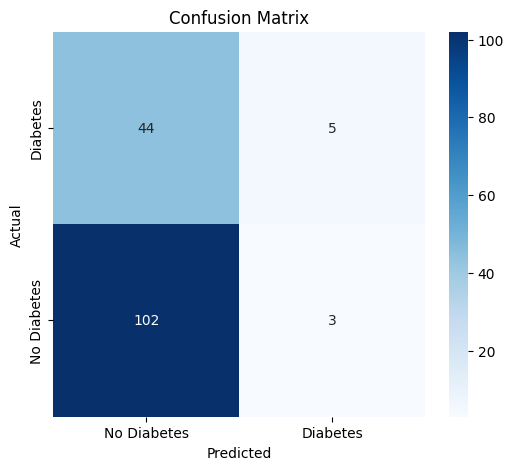

In [27]:
# Create a two column dataframe with the real outputs (test_df["diabetes_yes"]) and the predicted outputs res["pred_diabetes"]
# This will be used to calculate the accuracy of the model

results = pd.DataFrame({
    'Test': test_df["diabetes_yes"].values,
    'Pred': res["pred_diabetes"].values
})

# Calculate the accuracy of the model
accuracy = accuracy_score(results["Test"], results["Pred"])
print(f"Accuracy: {accuracy}")

# Compute confusion matrix
cm = confusion_matrix(results["Test"], results["Pred"])

# Plot confusion matrix
plt.figure(figsize=(6,5))
# invert x and y axis to match the confusion matrix plot

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Diabetes", "Diabetes"], yticklabels=["No Diabetes", "Diabetes"])

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
# Invert y-axis
plt.gca().invert_yaxis()
plt.show()

## Explanations

In [28]:
max_iterations = 10
min_covering = 2
max_failed_attempts = 15
min_fidelity = 1.0
lowest_fidelity_allowed = 0.9
use_minimal_version = True

explainer = TabularExplainer(
    explainers=["fidex", "fidexGloRules"],
    data=train_df,
    model=model_diabetes,
    mode="classification",
    params={
        "fidex": {
            "max_iterations": max_iterations,
            "attributes_file": features_filename,
            "min_covering": min_covering,
            "max_failed_attempts": max_failed_attempts,
            "min_fidelity": min_fidelity,
            "lowest_min_fidelity": lowest_fidelity_allowed,
        },
        "fidexGloRules": {
            "heuristic": 1,
            "with_fidexGlo": True,
            "fidexGlo": {
                "attributes_file": features_filename,
                "with_minimal_version": use_minimal_version,
                "max_iterations": max_iterations,
                "min_covering": min_covering,
                "covering_strategy": True,
                "max_failed_attempts": max_failed_attempts,
                "min_fidelity": min_fidelity,
                "lowest_min_fidelity": lowest_fidelity_allowed,
            },
            "attributes_file": features_filename,
            "nb_threads": 4,
            "with_minimal_version": use_minimal_version,
            "max_iterations": max_iterations,
            "min_covering": min_covering,
        },
    },
)

## Explanation dashboard

Note: With Google Colab, the global_explanation might generate an error. To circumvent this you can comment the global_explanations lines or execute the notebook locally. 

In [32]:
# predict with random sample
sample_to_test = test_df_tab#[randint(0, len(test_df)-1)]

# Create the explanations for all test samples
local_explainations = explainer.explain(X=sample_to_test)
global_explainations = explainer.explain_global()

dashboard = Dashboard(
    instances=sample_to_test,
    local_explanations=local_explainations,
    global_explanations=global_explainations,
    class_names=features[-nb_classes:],
)
dashboard.show()